In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from tqdm import tqdm

In [11]:
import numpy as np
import os

file_path = "/Volumes/my_own_SSD/updated_AreaX_outputs/USA5288/USA5288.npz"
data = np.load(file_path, allow_pickle=True)

print("Keys in npz:", data.files)
for k in data.files:
    arr = data[k]
    print(k, type(arr), getattr(arr, "shape", None), getattr(arr, "dtype", None))

Keys in npz: ['embedding_outputs', 'hdbscan_labels', 'ground_truth_labels', 'predictions', 's', 'hdbscan_colors', 'ground_truth_colors', 'original_spectogram', 'vocalization', 'file_indices', 'dataset_indices', 'file_map']
embedding_outputs <class 'numpy.ndarray'> (1001123, 2) float32
hdbscan_labels <class 'numpy.ndarray'> (1001123,) int64
ground_truth_labels <class 'numpy.ndarray'> (1001123,) int64
predictions <class 'numpy.ndarray'> (1001123, 196) float32
s <class 'numpy.ndarray'> (1001123, 196) float32
hdbscan_colors <class 'numpy.ndarray'> (28, 3) float64
ground_truth_colors <class 'numpy.ndarray'> (1, 3) float64
original_spectogram <class 'numpy.ndarray'> (1001123, 196) float32
vocalization <class 'numpy.ndarray'> (1001123,) int64
file_indices <class 'numpy.ndarray'> (1001123,) int64
dataset_indices <class 'numpy.ndarray'> (1001123,) int64
file_map <class 'numpy.ndarray'> () object


Num file segments: 308
First 10 segment file_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Viewing seg: 5 file_id: 5 name: ('USA5288_45377.28303567_3_26_7_51_43_segment_1.npz',) frames: 14099 18354


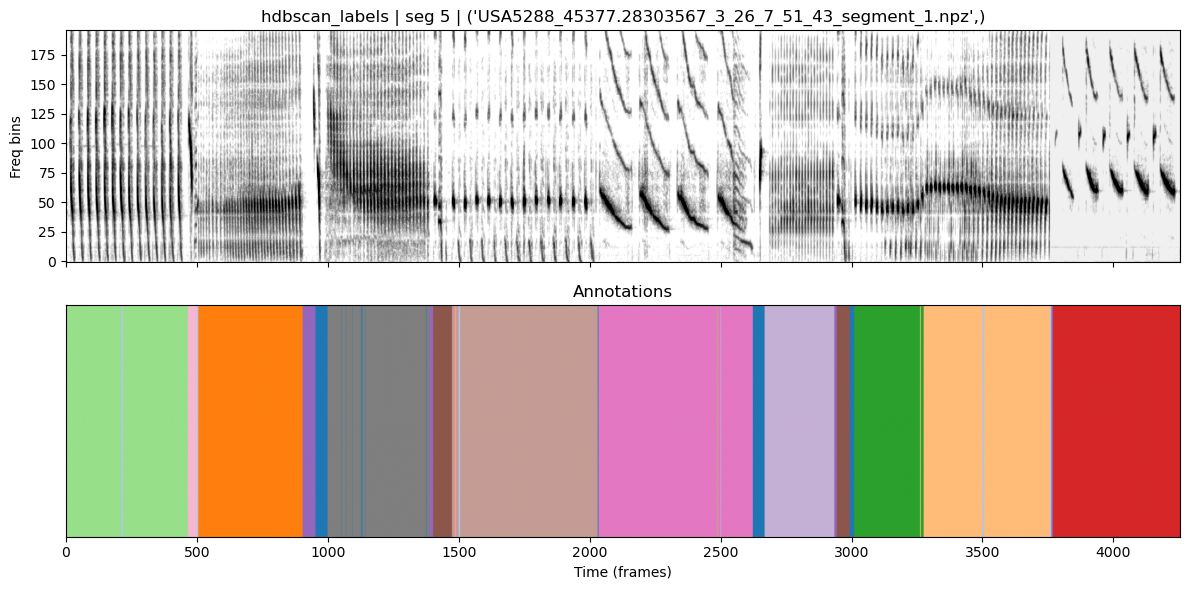

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

file_path = "/Volumes/my_own_SSD/updated_AreaX_outputs/USA5288/USA5288.npz"
data = np.load(file_path, allow_pickle=True)

S = data["s"]  # (T, F)
file_ids = data["file_indices"]  # (T,)

# Build segments based on changes in file_indices
change_pts = np.where(np.diff(file_ids) != 0)[0] + 1
starts = np.r_[0, change_pts]
ends = np.r_[change_pts, len(file_ids)]
segments = list(zip(starts, ends))

print("Num file segments:", len(segments))
print("First 10 segment file_ids:", [int(file_ids[s]) for s, e in segments[:10]])

# Optional: map file_id -> filename/path
fm = data["file_map"]
fm = fm.item() if hasattr(fm, "item") else fm  # often a dict stored as object
def file_name(fid):
    try:
        return fm.get(int(fid), str(fid))
    except Exception:
        return str(fid)

# Pick which "song/file" to view
seg_i = 5   # <-- change this
pad = 500

s0, e0 = segments[seg_i]
view_start = max(0, s0 - pad)
view_end = min(len(file_ids), e0 + pad)

print("Viewing seg:", seg_i,
      "file_id:", int(file_ids[s0]),
      "name:", file_name(file_ids[s0]),
      "frames:", view_start, view_end)

# Choose which annotation track to plot
label_key = "hdbscan_labels"  # or "ground_truth_labels"
labels = data[label_key][view_start:view_end]

# Plot (transpose S so it displays as freq x time)
S_view = S[view_start:view_end].T
vmin, vmax = np.percentile(S_view, [5, 99])

unique = np.unique(labels)
cmap = plt.get_cmap("tab20")
lab2col = {lab: cmap(i % cmap.N) for i, lab in enumerate(unique)}
lab_colors = np.array([lab2col[lab] for lab in labels])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax1.imshow(S_view, aspect="auto", origin="lower", cmap="gray_r", vmin=vmin, vmax=vmax)
ax1.set_title(f"{label_key} | seg {seg_i} | {file_name(file_ids[s0])}")
ax1.set_ylabel("Freq bins")

ax2.imshow(lab_colors[None, :, :], aspect="auto")
ax2.set_yticks([])
ax2.set_xlabel("Time (frames)")
ax2.set_title("Annotations")

plt.tight_layout()
plt.show()

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]


File: USA5288.npz
Using labels: hdbscan_labels
Segments found: 308 | viewing seg_i=0 frames 0:3168
Unique labels in view: [-1  6  7  8 12 15 16 17 18]


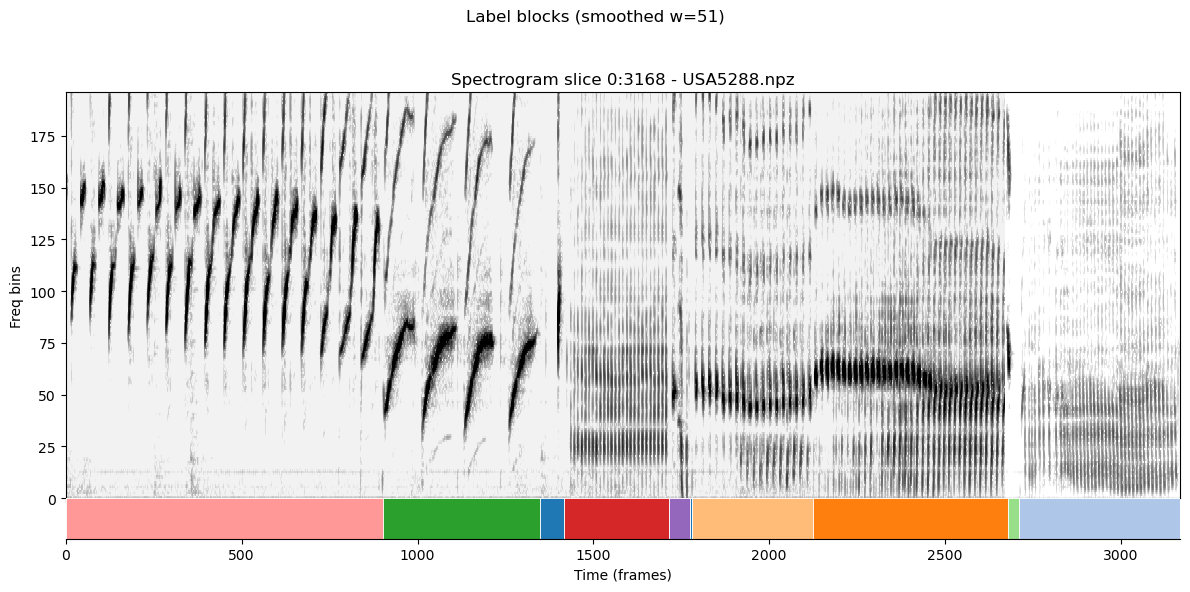

Processing files: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Processing complete.


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import defaultdict, deque
from matplotlib.patches import Rectangle

def smooth_labels_sliding_mode(labels: np.ndarray, w: int) -> np.ndarray:
    """
    Sliding-window label smoother:
      - For each position i, take a window of length w around i (centered; clipped at ends).
      - Replace labels[i] with the most frequent label in that window.
      - Tie-break: choose the label that appears FIRST in the window.
      - At start/end: window is dynamically clipped to available data.
    """
    labels = np.asarray(labels)
    if labels.ndim != 1:
        raise ValueError("labels must be a 1D array")
    if w <= 1 or labels.size == 0:
        return labels.copy()

    N = labels.size
    half_left = (w - 1) // 2
    half_right = (w - 1) - half_left

    counts = defaultdict(int)
    pos = defaultdict(deque)

    def add(j: int):
        lab = labels[j]
        counts[lab] += 1
        pos[lab].append(j)

    def remove(j: int):
        lab = labels[j]
        counts[lab] -= 1
        if pos[lab] and pos[lab][0] == j:
            pos[lab].popleft()
        else:
            try:
                pos[lab].remove(j)
            except ValueError:
                pass
        if counts[lab] <= 0:
            del counts[lab]
            del pos[lab]

    # init window for i=0 (clipped)
    L = 0
    R = min(N - 1, half_right)
    for j in range(L, R + 1):
        add(j)

    out = np.empty_like(labels)

    for i in range(N):
        best_lab = None
        best_count = -1
        best_firstpos = 10**18

        for lab, c in counts.items():
            firstpos = pos[lab][0]
            if (c > best_count) or (c == best_count and firstpos < best_firstpos):
                best_lab = lab
                best_count = c
                best_firstpos = firstpos

        out[i] = best_lab

        newL = max(0, (i + 1) - half_left)
        newR = min(N - 1, (i + 1) + half_right)

        while L < newL:
            remove(L); L += 1
        while R < newR:
            R += 1; add(R)

    return out


# ----------------------------
# CONFIG
# ----------------------------
folder_path = "/Volumes/my_own_SSD/updated_AreaX_outputs/USA5288"
npz_files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]

label_source = "hdbscan_labels"   # "ground_truth_labels" or "predictions"
seg_i = 0                         # which file_indices segment to view
pad = 500                         # frames before/after the chosen segment
max_plot_frames = 10_000          # cap long segments
smooth_w = 51                     # smoothing window length (1 disables)

label_bar_height = 0.10           # <-- thinner label bar (was ~0.18)
label_edge_lw = 0.6               # rectangle edge line width

for file in tqdm(npz_files[:50], desc="Processing files"):
    file_path = os.path.join(folder_path, file)
    data = np.load(file_path, allow_pickle=True)

    # --- spectrogram key ---
    if "s" in data.files:
        S = data["s"]  # (T, F)
    elif "original_spectogram" in data.files:
        S = data["original_spectogram"]
    else:
        raise KeyError(f"No spectrogram key found. Keys: {data.files}")

    T = S.shape[0]

    # --- choose labels ---
    if label_source == "predictions":
        labels_full = np.argmax(data["predictions"], axis=1)
        used_label_key = "predictions (argmax)"
    else:
        if label_source not in data.files:
            raise KeyError(f"'{label_source}' not found. Available keys: {data.files}")
        labels_full = data[label_source]
        used_label_key = label_source

    # --- choose segment (by file_indices changes) ---
    if "file_indices" in data.files:
        file_ids = data["file_indices"]
        change_pts = np.where(np.diff(file_ids) != 0)[0] + 1
        starts = np.r_[0, change_pts]
        ends = np.r_[change_pts, T]
        segments = list(zip(starts, ends))
    else:
        segments = [(0, T)]

    if seg_i >= len(segments):
        raise IndexError(f"seg_i={seg_i} but only {len(segments)} segment(s) found.")

    s0, e0 = segments[seg_i]
    view_start = max(0, s0 - pad)
    view_end = min(T, e0 + pad)

    if (view_end - view_start) > max_plot_frames:
        view_end = view_start + max_plot_frames

    # --- slice ---
    S_view = S[view_start:view_end].T
    lab_view = labels_full[view_start:view_end]

    # --- smooth labels ---
    if smooth_w > 1:
        lab_view = smooth_labels_sliding_mode(lab_view, smooth_w)

    print(f"\nFile: {file}")
    print(f"Using labels: {used_label_key}")
    print(f"Segments found: {len(segments)} | viewing seg_i={seg_i} frames {view_start}:{view_end}")
    print("Unique labels in view:", np.unique(lab_view))

    # --- contrast boost ---
    vmin, vmax = np.percentile(S_view, [5, 99])

    # --- label -> color map ---
    unique = np.unique(lab_view)
    cmap_lab = plt.get_cmap("tab20")
    lab2col = {lab: cmap_lab(i % cmap_lab.N) for i, lab in enumerate(unique)}

    # --- run-length encode labels into blocks ---
    frames = lab_view.size
    if frames == 0:
        continue

    change = np.where(lab_view[1:] != lab_view[:-1])[0] + 1
    run_starts = np.r_[0, change]
    run_ends = np.r_[change, frames]

    # ----------------------------
    # PLOT (no gap between axes)
    # ----------------------------
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 6), sharex=True,
        gridspec_kw={"height_ratios": [1.0, label_bar_height], "hspace": 0.0}  # <-- removes space
    )

    # Put the label-bar title ABOVE the spectrogram (as the figure title)
    fig.suptitle(f"Label blocks (smoothed w={smooth_w})", y=0.98)

    ax1.imshow(
        S_view,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        vmin=vmin, vmax=vmax,
        extent=(view_start, view_end, 0, S_view.shape[0]),
        interpolation="nearest"
    )
    ax1.set_ylabel("Freq bins")
    ax1.set_title(f"Spectrogram slice {view_start}:{view_end} - {file}", pad=6)

    # Label bar rectangles
    ax2.set_xlim(view_start, view_end)
    ax2.set_ylim(0, 1)
    ax2.set_yticks([])

    for rs, re in zip(run_starts, run_ends):
        lab = lab_view[rs]
        x0 = view_start + rs
        w = re - rs
        ax2.add_patch(
            Rectangle(
                (x0, 0),
                w, 1,
                facecolor=lab2col[lab],
                edgecolor="white",
                linewidth=label_edge_lw
            )
        )

    # Keep x ticks visible on the bottom axis
    ax2.set_xlabel("Time (frames)")
    ax2.tick_params(axis="x", labelbottom=True)

    # Strip aesthetics
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)

    # Tight layout while reserving room for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Processing complete.")

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

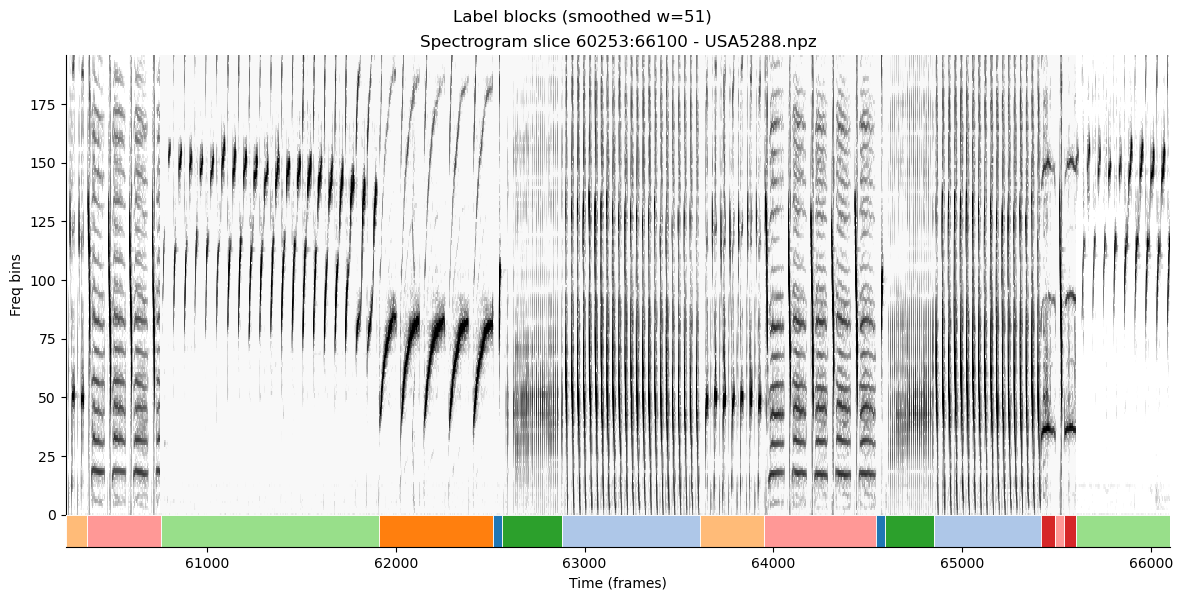

Processing files: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Processing complete.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import defaultdict, deque
from matplotlib.patches import Rectangle

def smooth_labels_sliding_mode(labels: np.ndarray, w: int) -> np.ndarray:
    labels = np.asarray(labels)
    if labels.ndim != 1:
        raise ValueError("labels must be a 1D array")
    if w <= 1 or labels.size == 0:
        return labels.copy()

    N = labels.size
    half_left = (w - 1) // 2
    half_right = (w - 1) - half_left

    counts = defaultdict(int)
    pos = defaultdict(deque)

    def add(j: int):
        lab = labels[j]
        counts[lab] += 1
        pos[lab].append(j)

    def remove(j: int):
        lab = labels[j]
        counts[lab] -= 1
        if pos[lab] and pos[lab][0] == j:
            pos[lab].popleft()
        else:
            try:
                pos[lab].remove(j)
            except ValueError:
                pass
        if counts[lab] <= 0:
            del counts[lab]
            del pos[lab]

    L = 0
    R = min(N - 1, half_right)
    for j in range(L, R + 1):
        add(j)

    out = np.empty_like(labels)

    for i in range(N):
        best_lab = None
        best_count = -1
        best_firstpos = 10**18

        for lab, c in counts.items():
            firstpos = pos[lab][0]
            if (c > best_count) or (c == best_count and firstpos < best_firstpos):
                best_lab = lab
                best_count = c
                best_firstpos = firstpos

        out[i] = best_lab

        newL = max(0, (i + 1) - half_left)
        newR = min(N - 1, (i + 1) + half_right)

        while L < newL:
            remove(L); L += 1
        while R < newR:
            R += 1; add(R)

    return out


# ----------------------------
# CONFIG
# ----------------------------
folder_path = "/Volumes/my_own_SSD/updated_AreaX_outputs/USA5288"
npz_files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]

label_source = "hdbscan_labels"   # "ground_truth_labels" or "predictions"
seg_i = 20                         # which file_indices segment to view
pad = 500                         # frames before/after the chosen segment
max_plot_frames = 10_000          # cap long segments
smooth_w = 51                     # smoothing window length (1 disables)

label_bar_height = 0.07           # thinner label strip
label_edge_lw = 0.6               # rectangle edge line width

for file in tqdm(npz_files[:50], desc="Processing files"):
    file_path = os.path.join(folder_path, file)
    data = np.load(file_path, allow_pickle=True)

    # --- spectrogram key ---
    if "s" in data.files:
        S = data["s"]  # (T, F)
    elif "original_spectogram" in data.files:
        S = data["original_spectogram"]
    else:
        raise KeyError(f"No spectrogram key found. Keys: {data.files}")

    T = S.shape[0]

    # --- choose labels ---
    if label_source == "predictions":
        labels_full = np.argmax(data["predictions"], axis=1)
        used_label_key = "predictions (argmax)"
    else:
        if label_source not in data.files:
            raise KeyError(f"'{label_source}' not found. Available keys: {data.files}")
        labels_full = data[label_source]
        used_label_key = label_source

    # --- choose segment (by file_indices changes) ---
    if "file_indices" in data.files:
        file_ids = data["file_indices"]
        change_pts = np.where(np.diff(file_ids) != 0)[0] + 1
        starts = np.r_[0, change_pts]
        ends = np.r_[change_pts, T]
        segments = list(zip(starts, ends))
    else:
        segments = [(0, T)]

    if seg_i >= len(segments):
        raise IndexError(f"seg_i={seg_i} but only {len(segments)} segment(s) found.")

    s0, e0 = segments[seg_i]
    view_start = max(0, s0 - pad)
    view_end = min(T, e0 + pad)

    if (view_end - view_start) > max_plot_frames:
        view_end = view_start + max_plot_frames

    # --- slice ---
    S_view = S[view_start:view_end].T            # (F, frames)
    lab_view = labels_full[view_start:view_end]  # (frames,)

    # --- smooth labels ---
    if smooth_w > 1:
        lab_view = smooth_labels_sliding_mode(lab_view, smooth_w)

    # --- contrast boost ---
    vmin, vmax = np.percentile(S_view, [5, 99])

    # --- label -> color map ---
    unique = np.unique(lab_view)
    cmap_lab = plt.get_cmap("tab20")
    lab2col = {lab: cmap_lab(i % cmap_lab.N) for i, lab in enumerate(unique)}

    # --- run-length encode labels into blocks ---
    frames = lab_view.size
    if frames == 0:
        continue

    change = np.where(lab_view[1:] != lab_view[:-1])[0] + 1
    run_starts = np.r_[0, change]
    run_ends = np.r_[change, frames]

    # ----------------------------
    # PLOT: flush axes + no top/right spines
    # ----------------------------
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[1.0, label_bar_height], hspace=0.0)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    fig.suptitle(f"Label blocks (smoothed w={smooth_w})", y=0.995)

    ax1.imshow(
        S_view,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        vmin=vmin, vmax=vmax,
        extent=(view_start, view_end, 0, S_view.shape[0]),
        interpolation="nearest"
    )
    ax1.set_xlim(view_start, view_end)
    ax1.set_ylabel("Freq bins")
    ax1.set_title(f"Spectrogram slice {view_start}:{view_end} - {file}", pad=6)

    # Remove x ticks on spectrogram panel so it sits flush
    ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    # Label blocks
    ax2.set_ylim(0, 1)
    ax2.set_yticks([])
    for rs, re in zip(run_starts, run_ends):
        lab = lab_view[rs]
        x0 = view_start + rs
        w = re - rs
        ax2.add_patch(Rectangle((x0, 0), w, 1, facecolor=lab2col[lab],
                                edgecolor="white", linewidth=label_edge_lw))

    ax2.set_xlabel("Time (frames)")
    ax2.tick_params(axis="x", top=False, labelbottom=True)

    # ---- remove spines (top/right) and clean the join ----
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # (optional but usually nicer for this style)
    ax1.spines["bottom"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)

    # Manual margins (avoid tight_layout reintroducing gaps)
    fig.subplots_adjust(left=0.07, right=0.99, bottom=0.10, top=0.92, hspace=0.0)

    plt.show()

print("Processing complete.")

### MORE sample songs!

Found 308 total segments; using 10 examples (filtered by min_segment_frames=800).


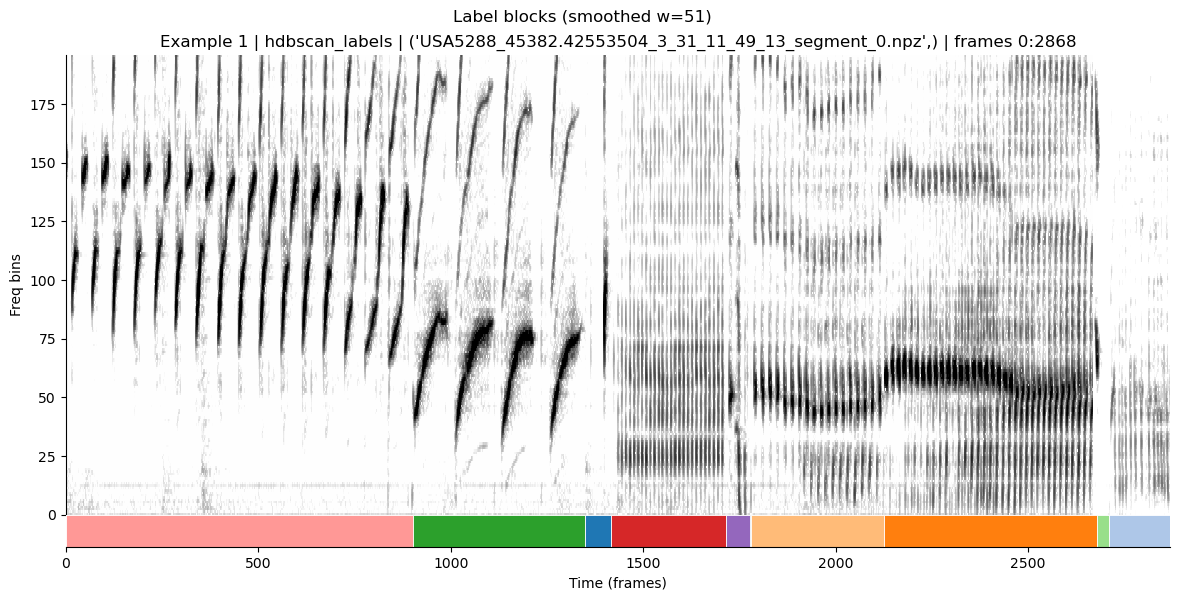

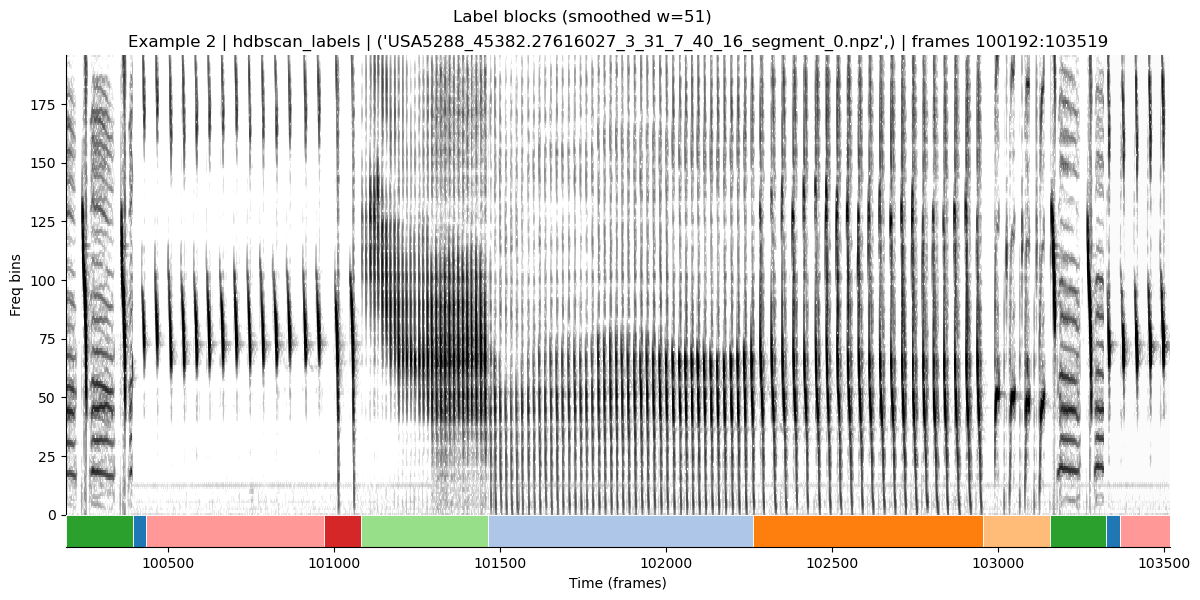

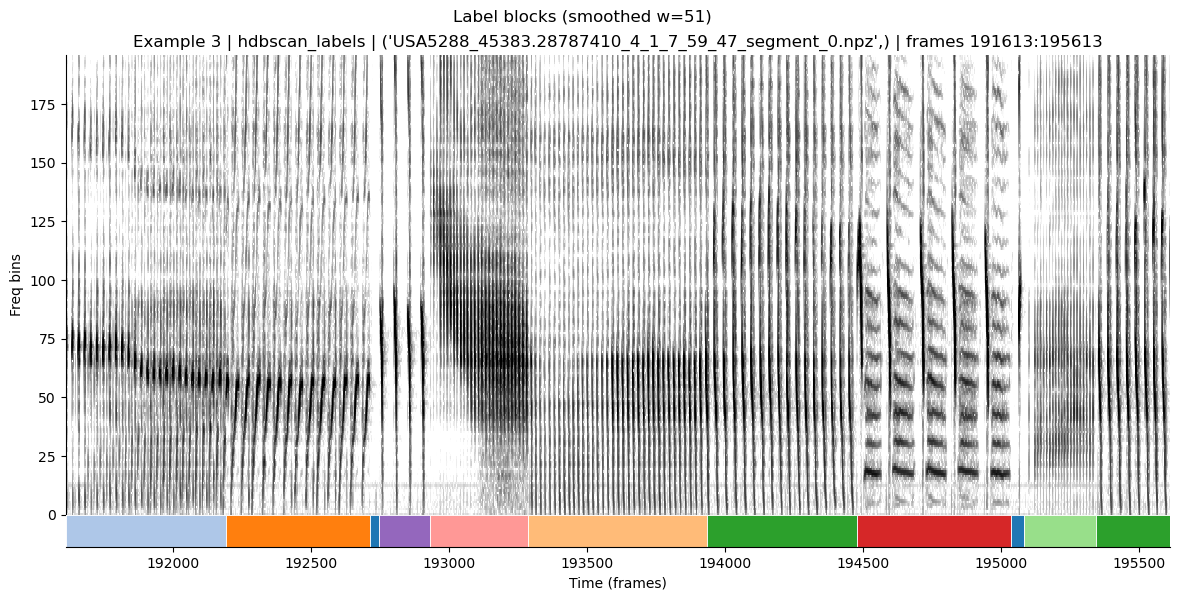

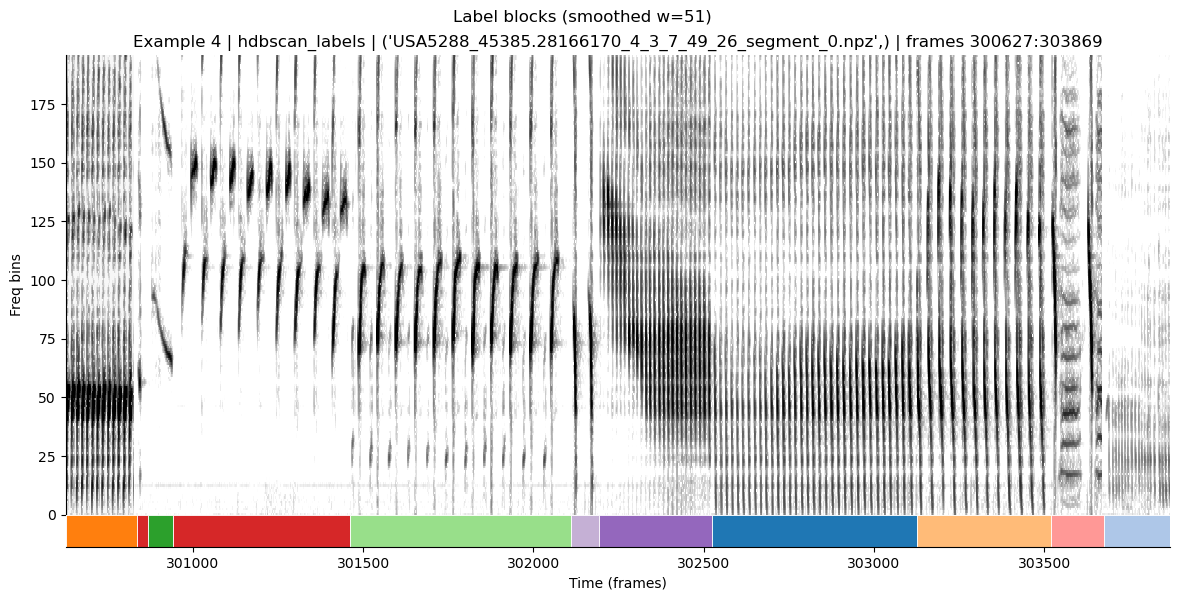

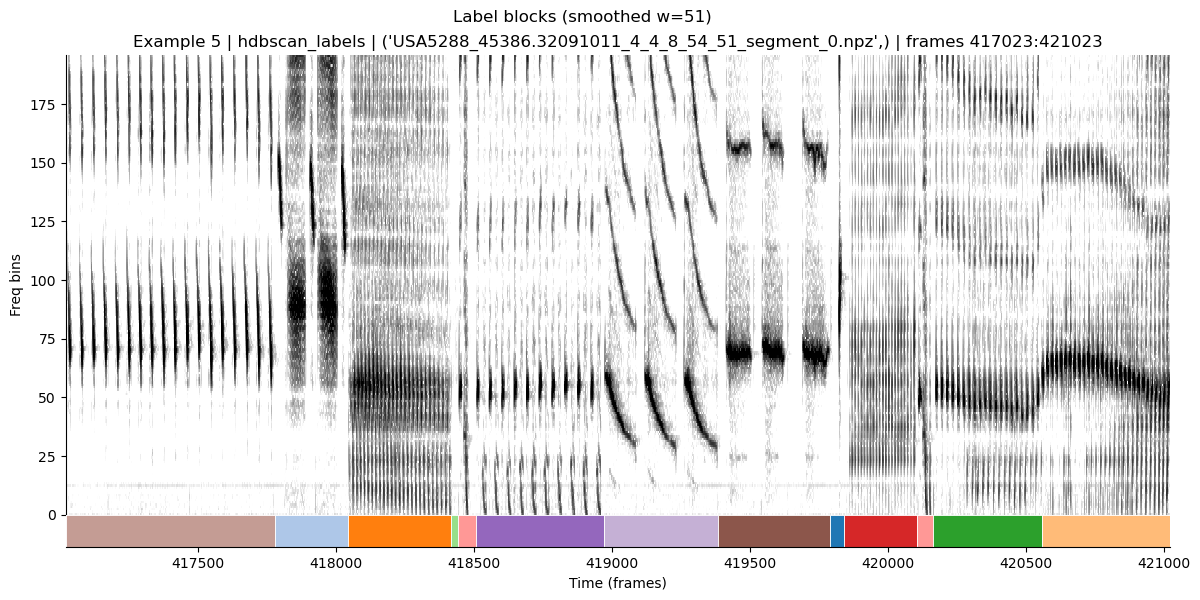

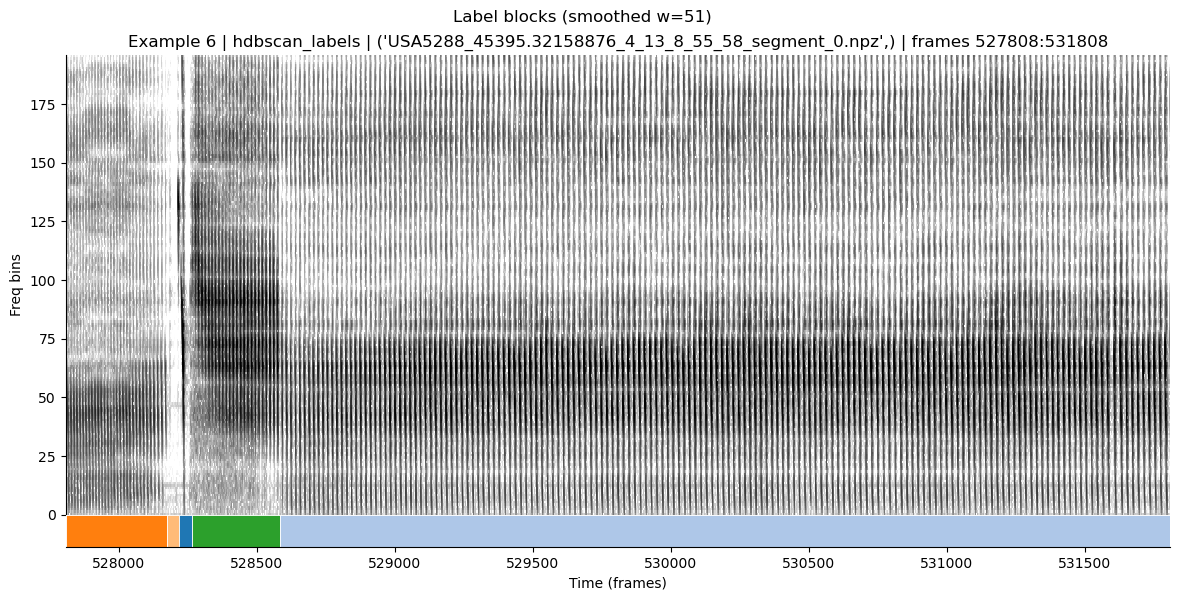

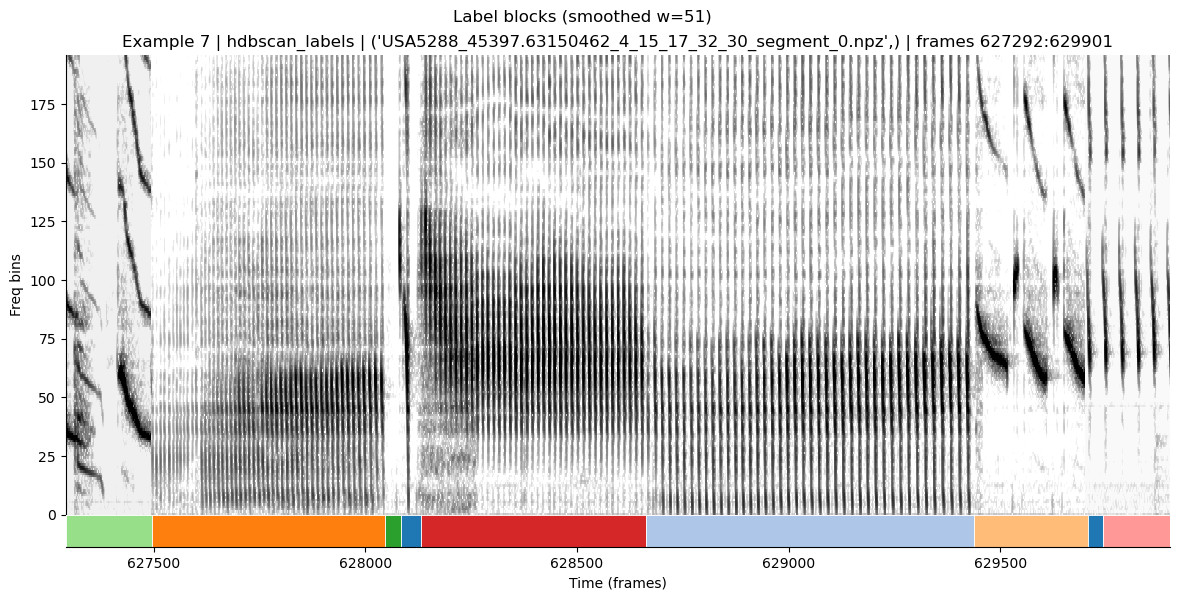

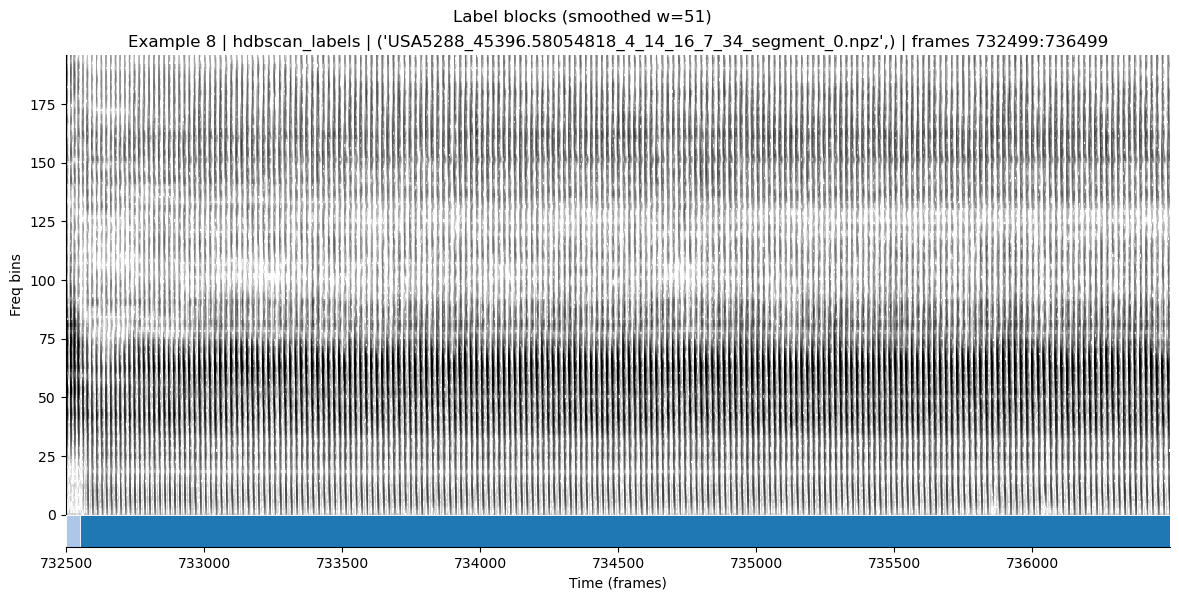

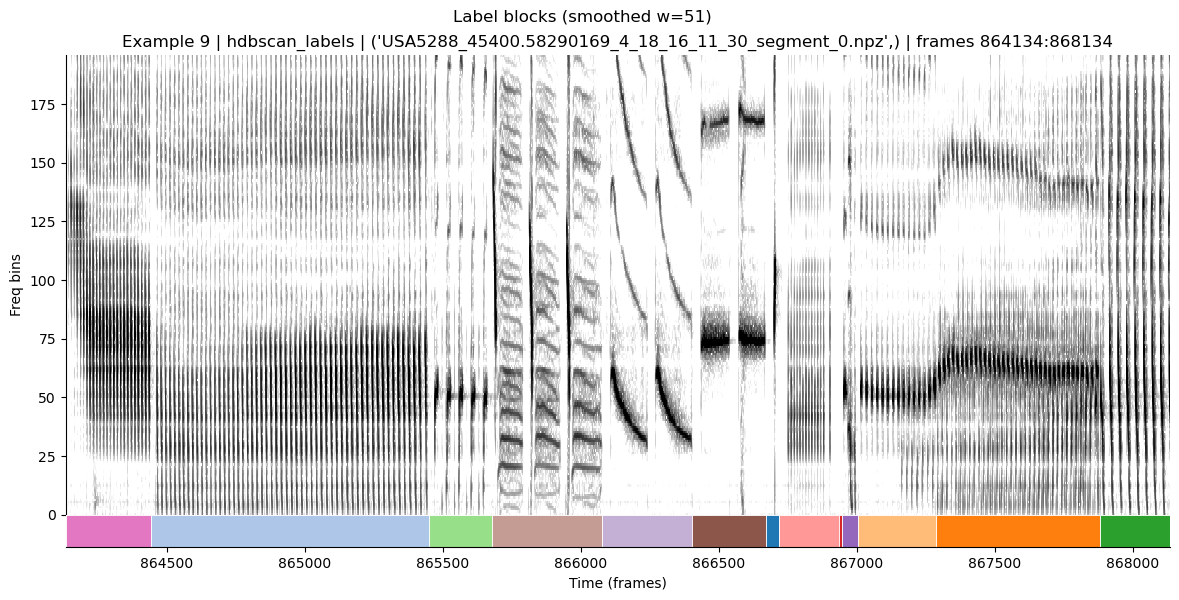

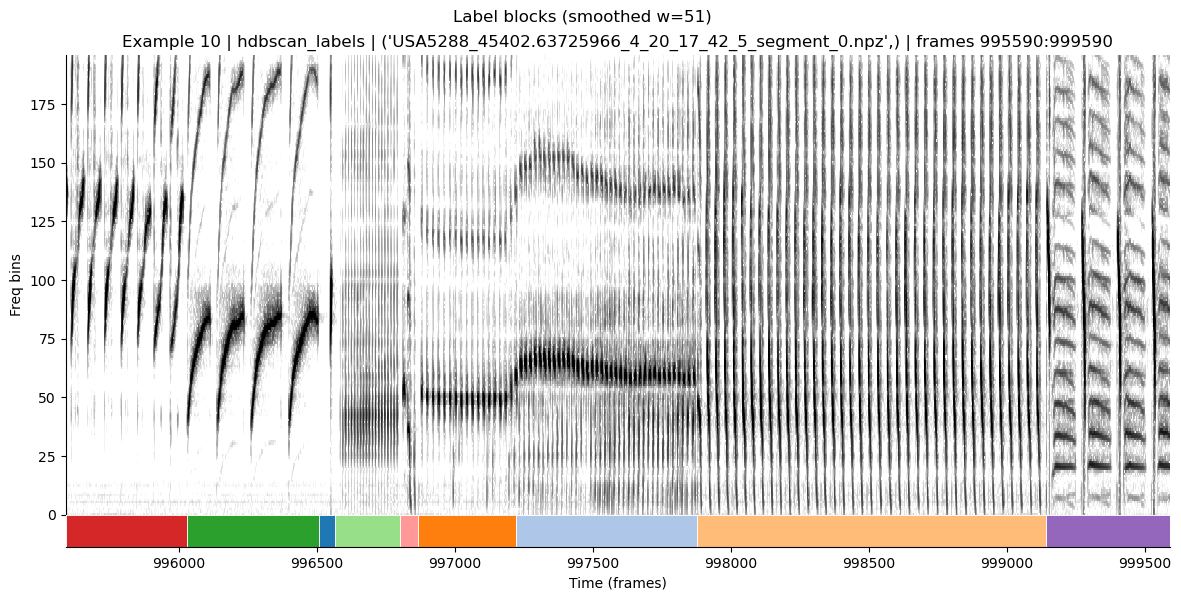

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from matplotlib.patches import Rectangle

def smooth_labels_sliding_mode(labels: np.ndarray, w: int) -> np.ndarray:
    labels = np.asarray(labels)
    if labels.ndim != 1:
        raise ValueError("labels must be a 1D array")
    if w <= 1 or labels.size == 0:
        return labels.copy()

    N = labels.size
    half_left = (w - 1) // 2
    half_right = (w - 1) - half_left

    counts = defaultdict(int)
    pos = defaultdict(deque)

    def add(j: int):
        lab = labels[j]
        counts[lab] += 1
        pos[lab].append(j)

    def remove(j: int):
        lab = labels[j]
        counts[lab] -= 1
        if pos[lab] and pos[lab][0] == j:
            pos[lab].popleft()
        else:
            try:
                pos[lab].remove(j)
            except ValueError:
                pass
        if counts[lab] <= 0:
            del counts[lab]
            del pos[lab]

    L = 0
    R = min(N - 1, half_right)
    for j in range(L, R + 1):
        add(j)

    out = np.empty_like(labels)
    for i in range(N):
        best_lab = None
        best_count = -1
        best_firstpos = 10**18
        for lab, c in counts.items():
            firstpos = pos[lab][0]
            if (c > best_count) or (c == best_count and firstpos < best_firstpos):
                best_lab = lab
                best_count = c
                best_firstpos = firstpos
        out[i] = best_lab

        newL = max(0, (i + 1) - half_left)
        newR = min(N - 1, (i + 1) + half_right)
        while L < newL:
            remove(L); L += 1
        while R < newR:
            R += 1; add(R)

    return out


# ----------------------------
# CONFIG (edit these)
# ----------------------------
file_path = "/Volumes/my_own_SSD/updated_AreaX_outputs/USA5288/USA5288.npz"

n_examples = 10                   # make 10 figures
label_source = "hdbscan_labels"   # "ground_truth_labels" or "predictions"
smooth_w = 51                     # smoothing window length (1 disables)

pad = 200                         # context around each song segment (in frames)
max_plot_frames = 4000            # cap very long songs (set larger if you want)
label_bar_height = 0.07           # thin label strip
label_edge_lw = 0.6               # rectangle edge line width
min_segment_frames = 800          # skip very short segments


# ----------------------------
# LOAD
# ----------------------------
data = np.load(file_path, allow_pickle=True)

# Spectrogram array (time, freq)
if "s" in data.files:
    S = data["s"]
elif "original_spectogram" in data.files:
    S = data["original_spectogram"]
else:
    raise KeyError(f"No spectrogram key found. Keys: {data.files}")
T = S.shape[0]

# Labels (time,)
if label_source == "predictions":
    labels_full = np.argmax(data["predictions"], axis=1)
    used_label_key = "predictions (argmax)"
else:
    if label_source not in data.files:
        raise KeyError(f"'{label_source}' not found. Keys: {data.files}")
    labels_full = data[label_source]
    used_label_key = label_source

# Optional file_id -> filename mapping for nicer titles
fm = data["file_map"] if "file_map" in data.files else None
if fm is not None and hasattr(fm, "item"):
    try:
        fm = fm.item()
    except Exception:
        pass

def file_name(fid):
    if isinstance(fm, dict):
        return str(fm.get(int(fid), fid))
    return str(fid)

# ----------------------------
# BUILD "SONG" SEGMENTS
# ----------------------------
# Best: use file_indices (different original files / songs)
if "file_indices" in data.files:
    file_ids = data["file_indices"]
    change_pts = np.where(np.diff(file_ids) != 0)[0] + 1
    starts = np.r_[0, change_pts]
    ends = np.r_[change_pts, T]
    segments = list(zip(starts, ends))
    seg_ids = [int(file_ids[s]) for s, e in segments]
else:
    # Fallback: if no file_indices, just split into chunks (still gives 10 different windows)
    chunk = max_plot_frames
    starts = np.arange(0, T, chunk)
    segments = [(int(s), int(min(T, s + chunk))) for s in starts]
    seg_ids = list(range(len(segments)))

# Filter out very short segments
kept = [(i, s, e, seg_ids[i]) for i, (s, e) in enumerate(segments) if (e - s) >= min_segment_frames]
if len(kept) == 0:
    raise RuntimeError("No segments passed the min_segment_frames filter. Lower min_segment_frames.")

# Pick ~10 different segments, spread across the recording
idxs = np.linspace(0, len(kept) - 1, min(n_examples, len(kept)), dtype=int)
chosen = [kept[i] for i in idxs]


# ----------------------------
# PLOT FUNCTION
# ----------------------------
def plot_segment(seg_num, s0, e0, fid):
    # pad around segment
    view_start = max(0, s0 - pad)
    view_end = min(T, e0 + pad)

    # if too long, center a fixed window on the segment
    if (view_end - view_start) > max_plot_frames:
        mid = (s0 + e0) // 2
        half = max_plot_frames // 2
        view_start = max(0, mid - half)
        view_end = min(T, view_start + max_plot_frames)

    # slice
    S_view = S[view_start:view_end].T             # (freq, time)
    lab_view = labels_full[view_start:view_end]   # (time,)

    # smooth
    if smooth_w > 1:
        lab_view = smooth_labels_sliding_mode(lab_view, smooth_w)

    # contrast
    vmin, vmax = np.percentile(S_view, [5, 99])

    # colors
    unique = np.unique(lab_view)
    cmap_lab = plt.get_cmap("tab20")
    lab2col = {lab: cmap_lab(i % cmap_lab.N) for i, lab in enumerate(unique)}

    # run-length encode blocks
    frames = lab_view.size
    change = np.where(lab_view[1:] != lab_view[:-1])[0] + 1
    run_starts = np.r_[0, change]
    run_ends = np.r_[change, frames]

    # figure (flush axes)
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[1.0, label_bar_height], hspace=0.0)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    fig.suptitle(f"Label blocks (smoothed w={smooth_w})", y=0.995)

    ax1.imshow(
        S_view,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        vmin=vmin, vmax=vmax,
        extent=(view_start, view_end, 0, S_view.shape[0]),
        interpolation="nearest"
    )
    ax1.set_xlim(view_start, view_end)
    ax1.set_ylabel("Freq bins")

    name = file_name(fid)
    ax1.set_title(f"Example {seg_num+1} | {used_label_key} | {name} | frames {view_start}:{view_end}", pad=6)

    # remove x ticks on spectrogram so it sits flush
    ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    # label blocks
    ax2.set_ylim(0, 1)
    ax2.set_yticks([])
    for rs, re in zip(run_starts, run_ends):
        lab = lab_view[rs]
        x0 = view_start + rs
        w = re - rs
        ax2.add_patch(Rectangle((x0, 0), w, 1,
                                facecolor=lab2col[lab],
                                edgecolor="white",
                                linewidth=label_edge_lw))

    ax2.set_xlabel("Time (frames)")

    # remove top/right spines (and clean the join)
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax2.spines["left"].set_visible(False)

    fig.subplots_adjust(left=0.07, right=0.99, bottom=0.10, top=0.92, hspace=0.0)
    plt.show()


# ----------------------------
# MAKE 10 FIGURES
# ----------------------------
print(f"Found {len(segments)} total segments; using {len(chosen)} examples (filtered by min_segment_frames={min_segment_frames}).")
for k, (orig_i, s0, e0, fid) in enumerate(chosen):
    plot_segment(k, s0, e0, fid)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from matplotlib.patches import Rectangle
import os

# ----------------------------
# CONFIG
# ----------------------------
npz_path = "/Volumes/my_own_SSD/updated_AreaX_outputs/USA5288/USA5288.npz"

label_source = "hdbscan_labels"   # "ground_truth_labels" or "predictions"
smooth_w = 51                     # smoothing window length (1 disables)

pad = 200                         # frames before/after the selected file segment
max_plot_frames = 6000            # cap very long files for viewing
label_bar_height = 0.07           # thin label strip
label_edge_lw = 0.6               # rectangle edge line width

# ----------------------------
# Smoother (your exact spec + tie-break)
# ----------------------------
def smooth_labels_sliding_mode(labels: np.ndarray, w: int) -> np.ndarray:
    labels = np.asarray(labels)
    if labels.ndim != 1:
        raise ValueError("labels must be a 1D array")
    if w <= 1 or labels.size == 0:
        return labels.copy()

    N = labels.size
    half_left = (w - 1) // 2
    half_right = (w - 1) - half_left

    counts = defaultdict(int)
    pos = defaultdict(deque)

    def add(j: int):
        lab = labels[j]
        counts[lab] += 1
        pos[lab].append(j)

    def remove(j: int):
        lab = labels[j]
        counts[lab] -= 1
        if pos[lab] and pos[lab][0] == j:
            pos[lab].popleft()
        else:
            try:
                pos[lab].remove(j)
            except ValueError:
                pass
        if counts[lab] <= 0:
            del counts[lab]
            del pos[lab]

    # init window for i=0 (clipped)
    L = 0
    R = min(N - 1, half_right)
    for j in range(L, R + 1):
        add(j)

    out = np.empty_like(labels)
    for i in range(N):
        best_lab = None
        best_count = -1
        best_firstpos = 10**18

        for lab, c in counts.items():
            firstpos = pos[lab][0]
            if (c > best_count) or (c == best_count and firstpos < best_firstpos):
                best_lab = lab
                best_count = c
                best_firstpos = firstpos

        out[i] = best_lab

        newL = max(0, (i + 1) - half_left)
        newR = min(N - 1, (i + 1) + half_right)

        while L < newL:
            remove(L); L += 1
        while R < newR:
            R += 1; add(R)

    return out

# ----------------------------
# Load NPZ + helpers
# ----------------------------
data = np.load(npz_path, allow_pickle=True)

# Spectrogram (time, freq)
if "s" in data.files:
    S = data["s"]
elif "original_spectogram" in data.files:
    S = data["original_spectogram"]
else:
    raise KeyError(f"No spectrogram key found. Keys: {data.files}")
T = S.shape[0]

# Labels (time,)
if label_source == "predictions":
    labels_full = np.argmax(data["predictions"], axis=1)
    used_label_key = "predictions (argmax)"
else:
    if label_source not in data.files:
        raise KeyError(f"'{label_source}' not found. Keys: {data.files}")
    labels_full = data[label_source]
    used_label_key = label_source

# Must have file_indices + file_map for lookup-by-wav-name
if "file_indices" not in data.files or "file_map" not in data.files:
    raise KeyError("Need 'file_indices' and 'file_map' in the npz to look up by wav name.")

file_indices = data["file_indices"]

file_map = data["file_map"]
# file_map is often stored as an object array containing a dict
if hasattr(file_map, "item"):
    try:
        file_map = file_map.item()
    except Exception:
        pass
if not isinstance(file_map, dict):
    raise TypeError(f"'file_map' is not a dict after .item(); got {type(file_map)}")

def _norm(s: str) -> str:
    return str(s).replace("\\", "/").lower()

def find_file_ids_by_wav(wav_query: str, match_basename_only: bool = True):
    """
    Return a list of (file_id, mapped_string) matches.
    - If match_basename_only=True, matches against basename (recommended).
    - wav_query can be full filename or a substring.
    """
    q = _norm(wav_query)
    matches = []
    for fid, path in file_map.items():
        p = _norm(path)
        target = os.path.basename(p) if match_basename_only else p
        if q in target:
            matches.append((int(fid), path))
    return matches

def plot_wav(wav_query: str, match_i: int = 0, match_basename_only: bool = True):
    """
    Find the file_id whose file_map matches wav_query, then plot that file's frames.
    If multiple matches, choose via match_i.
    """
    matches = find_file_ids_by_wav(wav_query, match_basename_only=match_basename_only)
    if len(matches) == 0:
        raise ValueError(
            f"No matches for '{wav_query}'. "
            f"Try a shorter substring (e.g., just the basename) or set match_basename_only=False."
        )

    print(f"Found {len(matches)} match(es) for '{wav_query}':")
    for j, (fid, p) in enumerate(matches[:20]):
        print(f"  [{j}] file_id={fid}  ->  {p}")
    if len(matches) > 20:
        print("  ... (more matches not shown)")

    if match_i < 0 or match_i >= len(matches):
        raise IndexError(f"match_i={match_i} out of range for {len(matches)} matches.")

    fid, p = matches[match_i]

    idx = np.where(file_indices == fid)[0]
    if idx.size == 0:
        raise RuntimeError(f"Found file_id={fid} in file_map, but no frames in file_indices.")

    # In most cases this is contiguous; if not, we still cover the full span.
    s0, e0 = int(idx.min()), int(idx.max()) + 1

    view_start = max(0, s0 - pad)
    view_end = min(T, e0 + pad)

    # cap for viewing
    if (view_end - view_start) > max_plot_frames:
        mid = (s0 + e0) // 2
        half = max_plot_frames // 2
        view_start = max(0, mid - half)
        view_end = min(T, view_start + max_plot_frames)

    # slice (S is time,freq) -> transpose for freq,time display
    S_view = S[view_start:view_end].T
    lab_view = labels_full[view_start:view_end]

    if smooth_w > 1:
        lab_view = smooth_labels_sliding_mode(lab_view, smooth_w)

    # contrast boost
    vmin, vmax = np.percentile(S_view, [5, 99])

    # label colors
    unique = np.unique(lab_view)
    cmap_lab = plt.get_cmap("tab20")
    lab2col = {lab: cmap_lab(i % cmap_lab.N) for i, lab in enumerate(unique)}

    # run-length encode into rectangles
    change = np.where(lab_view[1:] != lab_view[:-1])[0] + 1
    run_starts = np.r_[0, change]
    run_ends = np.r_[change, lab_view.size]

    # plot: flush axes + shared x
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 1, height_ratios=[1.0, label_bar_height], hspace=0.0)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    fig.suptitle(f"Label blocks (smoothed w={smooth_w})", y=0.995)

    ax1.imshow(
        S_view,
        aspect="auto",
        origin="lower",
        cmap="gray_r",
        vmin=vmin, vmax=vmax,
        extent=(view_start, view_end, 0, S_view.shape[0]),
        interpolation="nearest",
    )
    ax1.set_xlim(view_start, view_end)
    ax1.set_ylabel("Freq bins")
    ax1.set_title(f"{used_label_key} | {os.path.basename(str(p))} | frames {view_start}:{view_end}", pad=6)

    # remove x ticks on spectrogram (so it sits flush)
    ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    ax2.set_ylim(0, 1)
    ax2.set_yticks([])
    for rs, re in zip(run_starts, run_ends):
        lab = lab_view[rs]
        x0 = view_start + rs
        w = re - rs
        ax2.add_patch(Rectangle((x0, 0), w, 1,
                                facecolor=lab2col[lab],
                                edgecolor="white",
                                linewidth=label_edge_lw))

    ax2.set_xlabel("Time (frames)")

    # remove top/right spines
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax2.spines["left"].set_visible(False)

    fig.subplots_adjust(left=0.07, right=0.99, bottom=0.10, top=0.92, hspace=0.0)
    plt.show()

# ----------------------------
# USAGE
# ----------------------------
# Put ANY substring of the wav filename here (basename works best):
wav_query = "YOUR_WAV_FILE_NAME.wav"  # e.g., "USA5288_2024-04-01_123456.wav"

# If multiple matches print out, change match_i to pick another.
# plot_wav(wav_query, match_i=0)